# Introduction
This is a machine learning for Titanic.
We will start with: 

Descriptive information (exploratory)
1. What are the profiles of people who survive and not survive?
2. Is it true that kids and women are prioritized to survive?
3. How does the existence of siblings and parents affect the likelihood to survive?

Predictive information:
1. who are the ones that is more likely to survive


VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.  The following are the definitions used
for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins,
nephews/nieces, aunts/uncles, and in-laws.  Some children travelled
only with a nanny, therefore parch=0 for them.  As well, some
travelled with very close friends or neighbors in a village, however,
the definitions do not support such relations.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


maindf = pd.read_csv('input/train.csv')
testdf = pd.read_csv('input/test.csv')
maindf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
#Check columns informations
maindf.info()
print("----------------------------")
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare

In [3]:
# Create a train set descriptors and result

#Assumes that the PassengerID,name,ticket,cabin,and embarked do not matter
#Assumes that Fare is correlated to pclass
X = maindf.drop(['PassengerId','Survived','Name','Ticket','Cabin','Embarked','Fare'],axis=1)
Xtest = testdf.drop(['PassengerId','Name','Ticket','Cabin','Embarked','Fare'],axis=1)
y = maindf['Survived']

In [131]:
X.head()

,Pclass,Sex,Age,SibSp,Parch
0,3,male,22.0,1,0
1,1,female,38.0,1,0
2,3,female,26.0,0,0
3,1,female,35.0,1,0
4,3,male,35.0,0,0


## Data Preparation 

We will bin the data of:
1. Age
2. SibSp
3. Parch
4. Fare

In [132]:
X.shape

(891, 5)

In [133]:
X.describe()

,Pclass,Age,SibSp,Parch
count,891.000000,714.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594
std,0.836071,14.526497,1.102743,0.806057
min,1.000000,0.420000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000
50%,3.000000,28.000000,0.000000,0.000000
75%,3.000000,38.000000,1.000000,0.000000
max,3.000000,80.000000,8.000000,6.000000


In [134]:
#notice that the count of age is below than 714, indicate that there are empty values
#What are the empty values in each column of X
X.apply(lambda x: sum(x.isnull()),axis=0) 

Pclass      0
Sex         0
Age       177
SibSp       0
Parch       0
dtype: int64

In [135]:
#Refill empty values with Mean
X['Age'].fillna(maindf['Age'].mean(), inplace=True)
Xtest['Age'].fillna(testdf['Age'].mean(), inplace=True)

#### Age
**In order to better characterize the sample, the age range was classified according to growth stages: childhood (2 to 10 years), adolescence (11 to 17 years), young adult (18 to 40 years), adult (41 to 65 years) and elderly (> 65 years)**

#### Fare
**Min to First Quarter is Low, Quarter 1 to Quarter 2 is med, Quarter 2 to Quarter 3 is high, and Quarter 3 to quarter 4 is very high**

#### Sex
**Will be map to number male = 0 , female = 1**

In [136]:
age_bins = [0, 2, 10, 17, 40, 65, 100]
age_group = [0,1,2,3,4,5]
X['Age']= pd.cut(X['Age'], age_bins, labels=age_group)
# age_group = ['baby', 'child', 'adolescence', 'young adult','adult','elderly']
Xtest['Age']= pd.cut(Xtest['Age'], age_bins, labels=age_group)

# fare_bins = [0,7.910400, 14.454200, 31.000000, 512.329200]
# fare_group = ['low', 'med', 'high', 'very high']
# X['Fare']= pd.cut(X['Fare'], fare_bins, labels=fare_group)


In [137]:
#Map Sex to 0,1
X['Sex'] = X['Sex'].map({'male':0,'female':1})
Xtest['Sex'] = Xtest['Sex'].map({'male':0,'female':1})

In [138]:
#SibSp would only care if the person brings spouse or sibling
#Parch would only care if the person brings parent or children

X['SibSp'][X['SibSp']>0]=1
X['Parch'][X['Parch']>0]=1
Xtest['SibSp'][Xtest['SibSp']>0]=1
Xtest['Parch'][Xtest['Parch']>0]=1

# X['WithSomebody'] = X['SibSp']+X['Parch']
X.head()

D:\Anaconda\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://p

,Pclass,Sex,Age,SibSp,Parch
0,3,0,3,1,0
1,1,1,3,1,0
2,3,1,3,0,0
3,1,1,3,1,0
4,3,0,3,0,0


In [139]:
X.shape

(891, 5)

In [140]:
y.shape

(891L,)

### Is it true that kids and women are prioritized to survive? 

In [141]:
kidsorwoman = y[(X['Age']<3) | (X['Sex'] == 1)]
kidsorwoman.value_counts()
#From this result we know that kids or women are more likely to survive than die.

1    256
0    116
Name: Survived, dtype: int64

### How does the existence of siblings and parents affect the likelihood to survive?

In [142]:
nosiblingorparent = y[X['SibSp']+ X['Parch']<1]
hassiblingorparent = y[X['SibSp']+ X['Parch']>=1]
print(nosiblingorparent.value_counts())
print('____________________')
print(hassiblingorparent.value_counts())

#From here we can see that the likelihood to survive is more if a person has anyone with him/her

0    374
1    163
Name: Survived, dtype: int64
____________________
1    179
0    175
Name: Survived, dtype: int64


## Training the model

In [143]:
import numpy as np
from sklearn import preprocessing,cross_validation
from sklearn.tree import DecisionTreeClassifier

In [144]:
#splitting the train and test sets
X_train, X_test, y_train,y_test= cross_validation.train_test_split(X,y,test_size=0.2)

## DecisionTree Model Train

In [145]:
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [146]:
pd.DataFrame(X_train,y_train).head()
accuracy = clf.score(X_test,y_test)
print(accuracy)

0.776536312849


## Training Multiple Classifiers and Test Them

In [147]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 78.7709%
Log Loss: 2.6426461131
SVC
****Results****
Accuracy: 67.0391%
Log Loss: 0.522581206138
DecisionTreeClassifier
****Results****
Accuracy: 77.6536%
Log Loss: 1.74586059933
RandomForestClassifier
****Results****
Accuracy: 77.6536%
Log Loss: 1.2305511059
AdaBoostClassifier
****Results****
Accuracy: 73.1844%
Log Loss: 0.6824879064
GradientBoostingClassifier
****Results****
Accuracy: 77.0950%
Log Loss: 0.542267558603
GaussianNB
****Results****
Accuracy: 73.7430%
Log Loss: 0.68159249862
LinearDiscriminantAnalysis
****Results****
Accuracy: 74.3017%
Log Loss: 0.560906316933
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 75.4190%
Log Loss: 0.648358256823


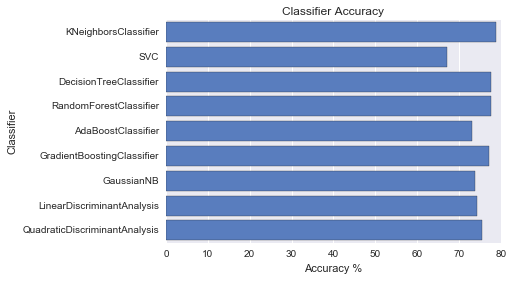

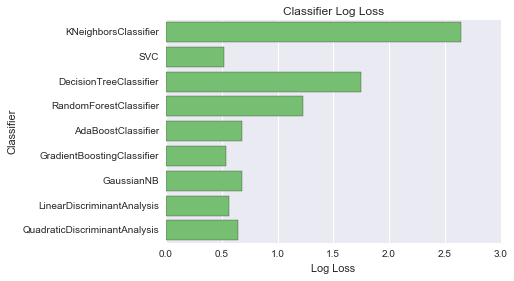

In [148]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

In [149]:
# Predict Test Set

favorite_clf = RandomForestClassifier()
favorite_clf.fit(X_train, y_train)
y_pred = pd.DataFrame(favorite_clf.predict(Xtest))

In [150]:
# Tidy and Export Submission
submission = pd.DataFrame({
        "PassengerId": testdf["PassengerId"]    
    })
submission['Survived'] = y_pred

submission.to_csv('submission.csv', index = False)
submission.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0


In [151]:
submission.shape

(418, 2)